# Multiple Instance Data Generation for Stage-3

## Goal

Given a 3D mesh model of an object, generate images with multiple instances of the object in the image and their corresponding object masks for different viewing angles of the object.

In [23]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRasterizer,
    MeshRenderer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesVertex
)
from pytorch3d.renderer.blending import (
    BlendParams,
    sigmoid_alpha_blend
)



In [37]:
#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

In [3]:
# setup cuda/cpu device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device=device)
    # clear cache
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

# setup data
DATA_DIR = "../data/model/packet/"
obj_file = os.path.join(DATA_DIR, "mesh.obj")

# load mesh obj
mesh = load_objs_as_meshes([obj_file], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)))

0.9755671


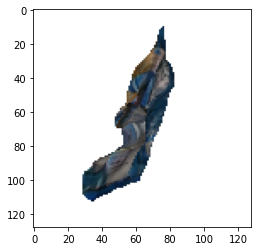

In [4]:
elev = [0]
azim = [180]
# num_views = 1
# elev = torch.linspace(0, 360, num_views)
# azim = torch.linspace(-180, 180, num_views)
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    device = device
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
image_size = 128
raster_settings = RasterizationSettings(
    image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader = SoftPhongShader(device=device, lights=lights, cameras=camera)
)

rendered_images = renderer(mesh, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image[...,3].max())
plt.imshow(image[...,:3])

# meshes = mesh.extend(num_views)
# rendered_images = renderer(meshes, cameras=camera)
# image_grid(rendered_images.cpu().numpy(), rows=1, cols=2, rgb=True)
# plt.show()

(128, 128, 4)
1.0
(128, 128, 4)


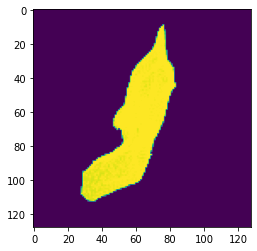

In [20]:
elev = [0]
azim = [180]
# num_views = 1
# elev = torch.linspace(0, 360, num_views)
# azim = torch.linspace(-180, 180, num_views)
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    device = device
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
image_size = 128
sigma = 1e-4
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

raster_settings2 = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0001, 
    faces_per_pixel=50, 
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings2),
    shader = SoftSilhouetteShader()
)

rendered_images = renderer(mesh, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image.shape)
print(image[...,3].max())
plt.imshow(image[...,3])
print(image.shape)

(128, 128, 1)
1.0
(128, 128, 1)


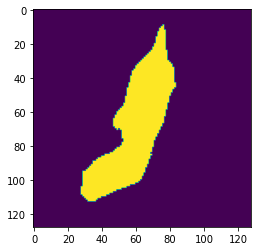

In [33]:
class SimpleShader(torch.nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        N, H, W, K = fragments.pix_to_face.shape
        device = fragments.pix_to_face.device

        # background mask
        is_background = fragments.pix_to_face[..., 0] < 0
        is_background = is_background.unsqueeze(3)
        bg = torch.zeros((N,H,W,1)).to(device)
        #fg = torch.ones((N,H,W,1)).to(device)
        fg = torch.stack([torch.ones(H,W,1) * i for i in range(1,N+1)]).to(device)
        images = bg + (~is_background * fg)
        # colors = torch.ones_like(fragments.bary_coords)
        #blend_params = kwargs.get("blend_params", BlendParams())
        #images = sigmoid_alpha_blend(colors, fragments, blend_params)
        return images # (N, H, W, 1) RGBA image

elev = [0]
azim = [180]
# num_views = 1
# elev = torch.linspace(0, 360, num_views)
# azim = torch.linspace(-180, 180, num_views)
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    device = device
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
image_size = 128
sigma = 1e-4
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

raster_settings2 = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0001, 
    faces_per_pixel=50, 
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings2),
    shader = SimpleShader()
)

rendered_images = renderer(mesh, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.imshow(image[...,0])
print(image.shape)

/home/kln/sandbox/cmu/repos/capstone/ners/external/pytorch3d-0.6.1/pytorch3d/transforms/transform3d.py:780: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


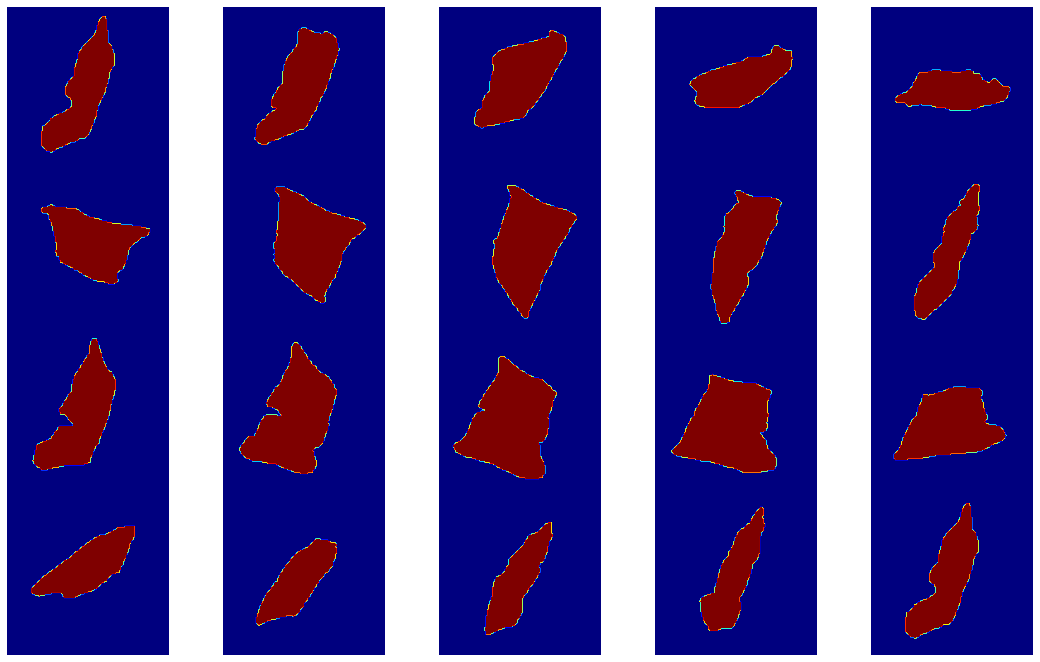

In [40]:
import matplotlib.pyplot as plt


def custom_image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 0], cmap='jet')
        if not show_axes:
            ax.set_axis_off()

class SimpleShader(torch.nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        N, H, W, K = fragments.pix_to_face.shape
        device = fragments.pix_to_face.device

        # background mask
        is_background = fragments.pix_to_face[..., 0] < 0
        is_background = is_background.unsqueeze(3)
        bg = torch.zeros((N,H,W,1)).to(device)
        #fg = torch.ones((N,H,W,1)).to(device)
        fg = torch.stack([torch.ones(H,W,1) * i for i in range(1,N+1)]).to(device)
        images = bg + (~is_background * fg)
        # colors = torch.ones_like(fragments.bary_coords)
        #blend_params = kwargs.get("blend_params", BlendParams())
        #images = sigmoid_alpha_blend(colors, fragments, blend_params)
        return images # (N, H, W, 1) RGBA image

# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the object is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SimpleShader()
)

# Create a batch of meshes by repeating the mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 0] for i in range(num_views)]

# Visualize silhouette images
custom_image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [46]:
print(silhouette_images.shape)

for i, img in enumerate(silhouette_images.cpu().numpy()):
    (x,y) = np.where(img[:,:,0] > 0)
    m = img[x,y].mean()
    print(i, m, x.shape, y.shape, np.sqrt(x.shape))

torch.Size([20, 128, 128, 1])
0 1.0 (2654,) (2654,) [51.51698749]
1 2.0 (3071,) (3071,) [55.41660401]
2 3.0 (3066,) (3066,) [55.3714728]
3 4.0 (2261,) (2261,) [47.54997371]
4 5.0 (2020,) (2020,) [44.94441011]
5 6.0 (2915,) (2915,) [53.99073995]
6 7.0 (3764,) (3764,) [61.3514466]
7 8.0 (3797,) (3797,) [61.61980201]
8 9.0 (3091,) (3091,) [55.5967625]
9 10.0 (2235,) (2235,) [47.27578661]
10 11.0 (3199,) (3199,) [56.55970297]
11 12.0 (4222,) (4222,) [64.97691898]
12 13.0 (4568,) (4568,) [67.58698099]
13 14.0 (4188,) (4188,) [64.71475875]
14 15.0 (3277,) (3277,) [57.24508713]
15 16.0 (2290,) (2290,) [47.85394446]
16 17.0 (2054,) (2054,) [45.32107677]
17 18.0 (2058,) (2058,) [45.36518489]
18 19.0 (2156,) (2156,) [46.43274706]
19 20.0 (2654,) (2654,) [51.51698749]


(128, 128, 1)
1.0
(128, 128, 1)


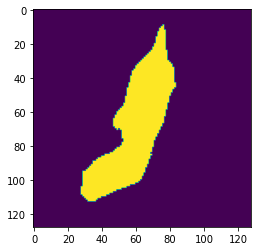

In [54]:
class MeshRendererWithDepth(torch.nn.Module):
    def __init__(self, rasterizer, shader):
        super().__init__()
        self.rasterizer = rasterizer
        self.shader = shader

    def forward(self, meshes_world, **kwargs) -> torch.Tensor:
        fragments = self.rasterizer(meshes_world, **kwargs)
        images = self.shader(fragments, meshes_world, **kwargs)
        return images, fragments.zbuf

elev = [0]
azim = [180]
# num_views = 1
# elev = torch.linspace(0, 360, num_views)
# azim = torch.linspace(-180, 180, num_views)
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    device = device
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
image_size = 128
sigma = 1e-4
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

raster_settings2 = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0001, 
    faces_per_pixel=50, 
)
renderer = MeshRendererWithDepth(
    rasterizer=MeshRasterizer(raster_settings=raster_settings2),
    shader = SimpleShader()
)

rendered_images, depth = renderer(mesh, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.imshow(image[...,0])
print(image.shape)

(1, 128, 128, 50)
(128, 128)
0.0 4.375


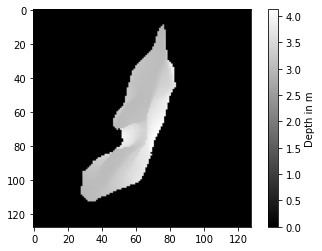

In [63]:
d = depth.cpu().numpy() + 1
print(d.shape)
print(d[0,:,:,0].shape)
print(d.min(), d.max())
plt.figure()
plt.imshow(d[0,:,:,0], cmap='gray')
plt.colorbar(label="Depth in m")
plt.show()

In [7]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the object is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

/home/kln/sandbox/cmu/repos/capstone/ners/external/pytorch3d-0.6.1/pytorch3d/transforms/transform3d.py:780: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


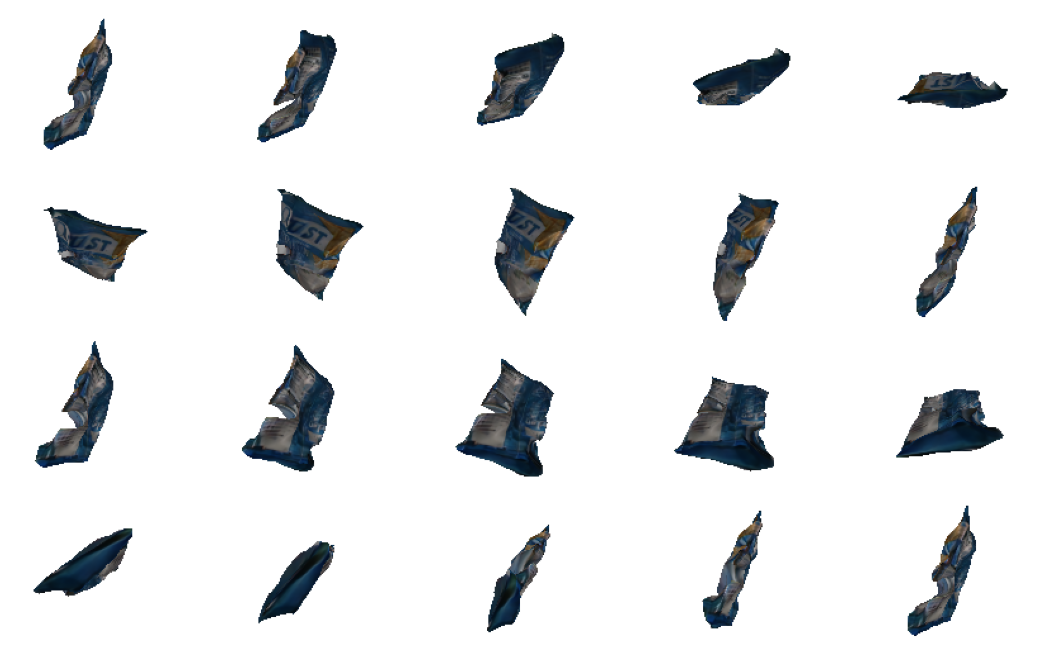

In [8]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

/home/kln/sandbox/cmu/repos/capstone/ners/external/pytorch3d-0.6.1/pytorch3d/transforms/transform3d.py:780: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


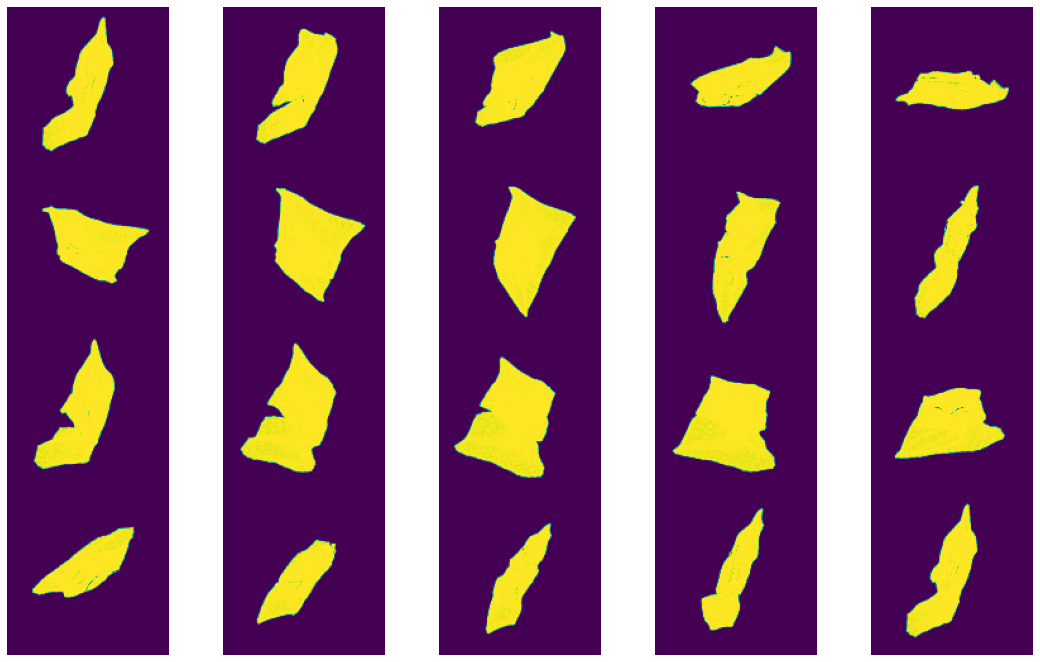

In [12]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [ ]:
X = torch.ones((5,3,3,1))